# Forecasting Mini-Course Sales

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# Загрузка данных

In [13]:
data = pd.read_csv("data.csv")
# Преобразование столбца `date` в формат datetime
data['date'] = pd.to_datetime(data['date'])

# Обзор данных

In [14]:
print("Общие сведения о данных:")
data.info()
print("\nПервые строки данных:")
print(data.head())
print("\nОсновные статистики числовых данных:")

print(data.describe())

Общие сведения о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB

Первые строки данных:
   id       date    country         store  \
0   0 2017-01-01  Argentina  Kaggle Learn   
1   1 2017-01-01  Argentina  Kaggle Learn   
2   2 2017-01-01  Argentina  Kaggle Learn   
3   3 2017-01-01  Argentina  Kaggle Learn   
4   4 2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1 

In [15]:
print("\nПроверка пропущенных значений:")
print(data.isnull().sum())


Проверка пропущенных значений:
id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64


# Анализ числовых переменных

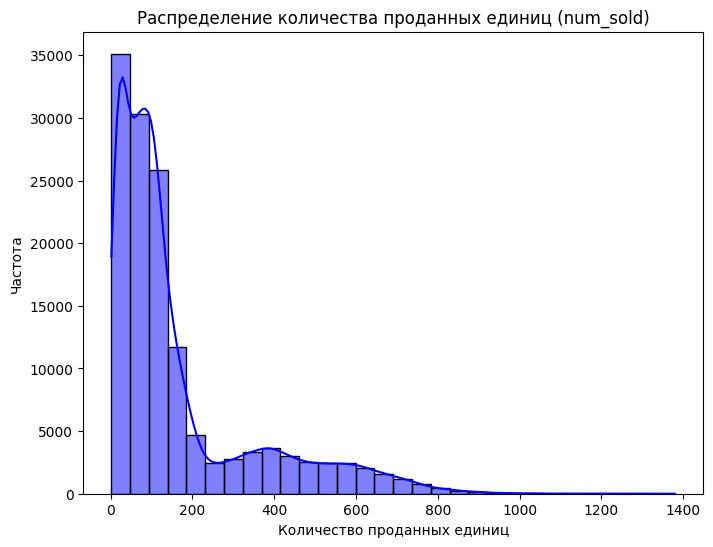

In [16]:
# Гистограмма распределения `num_sold`
plt.figure(figsize=(8, 6))
sns.histplot(data['num_sold'], bins=30, kde=True, color='blue')
plt.title("Распределение количества проданных единиц (num_sold)")
plt.xlabel("Количество проданных единиц")
plt.ylabel("Частота")
plt.show()

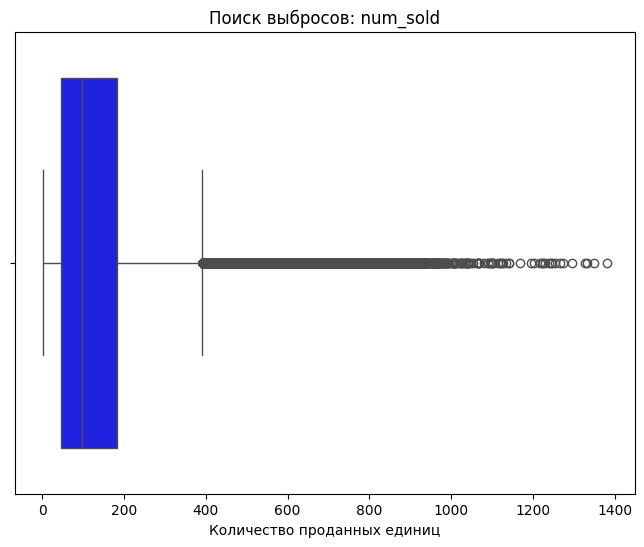

In [17]:
# Boxplot для поиска выбросов
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['num_sold'], color='blue')
plt.title("Поиск выбросов: num_sold")
plt.xlabel("Количество проданных единиц")
plt.show()

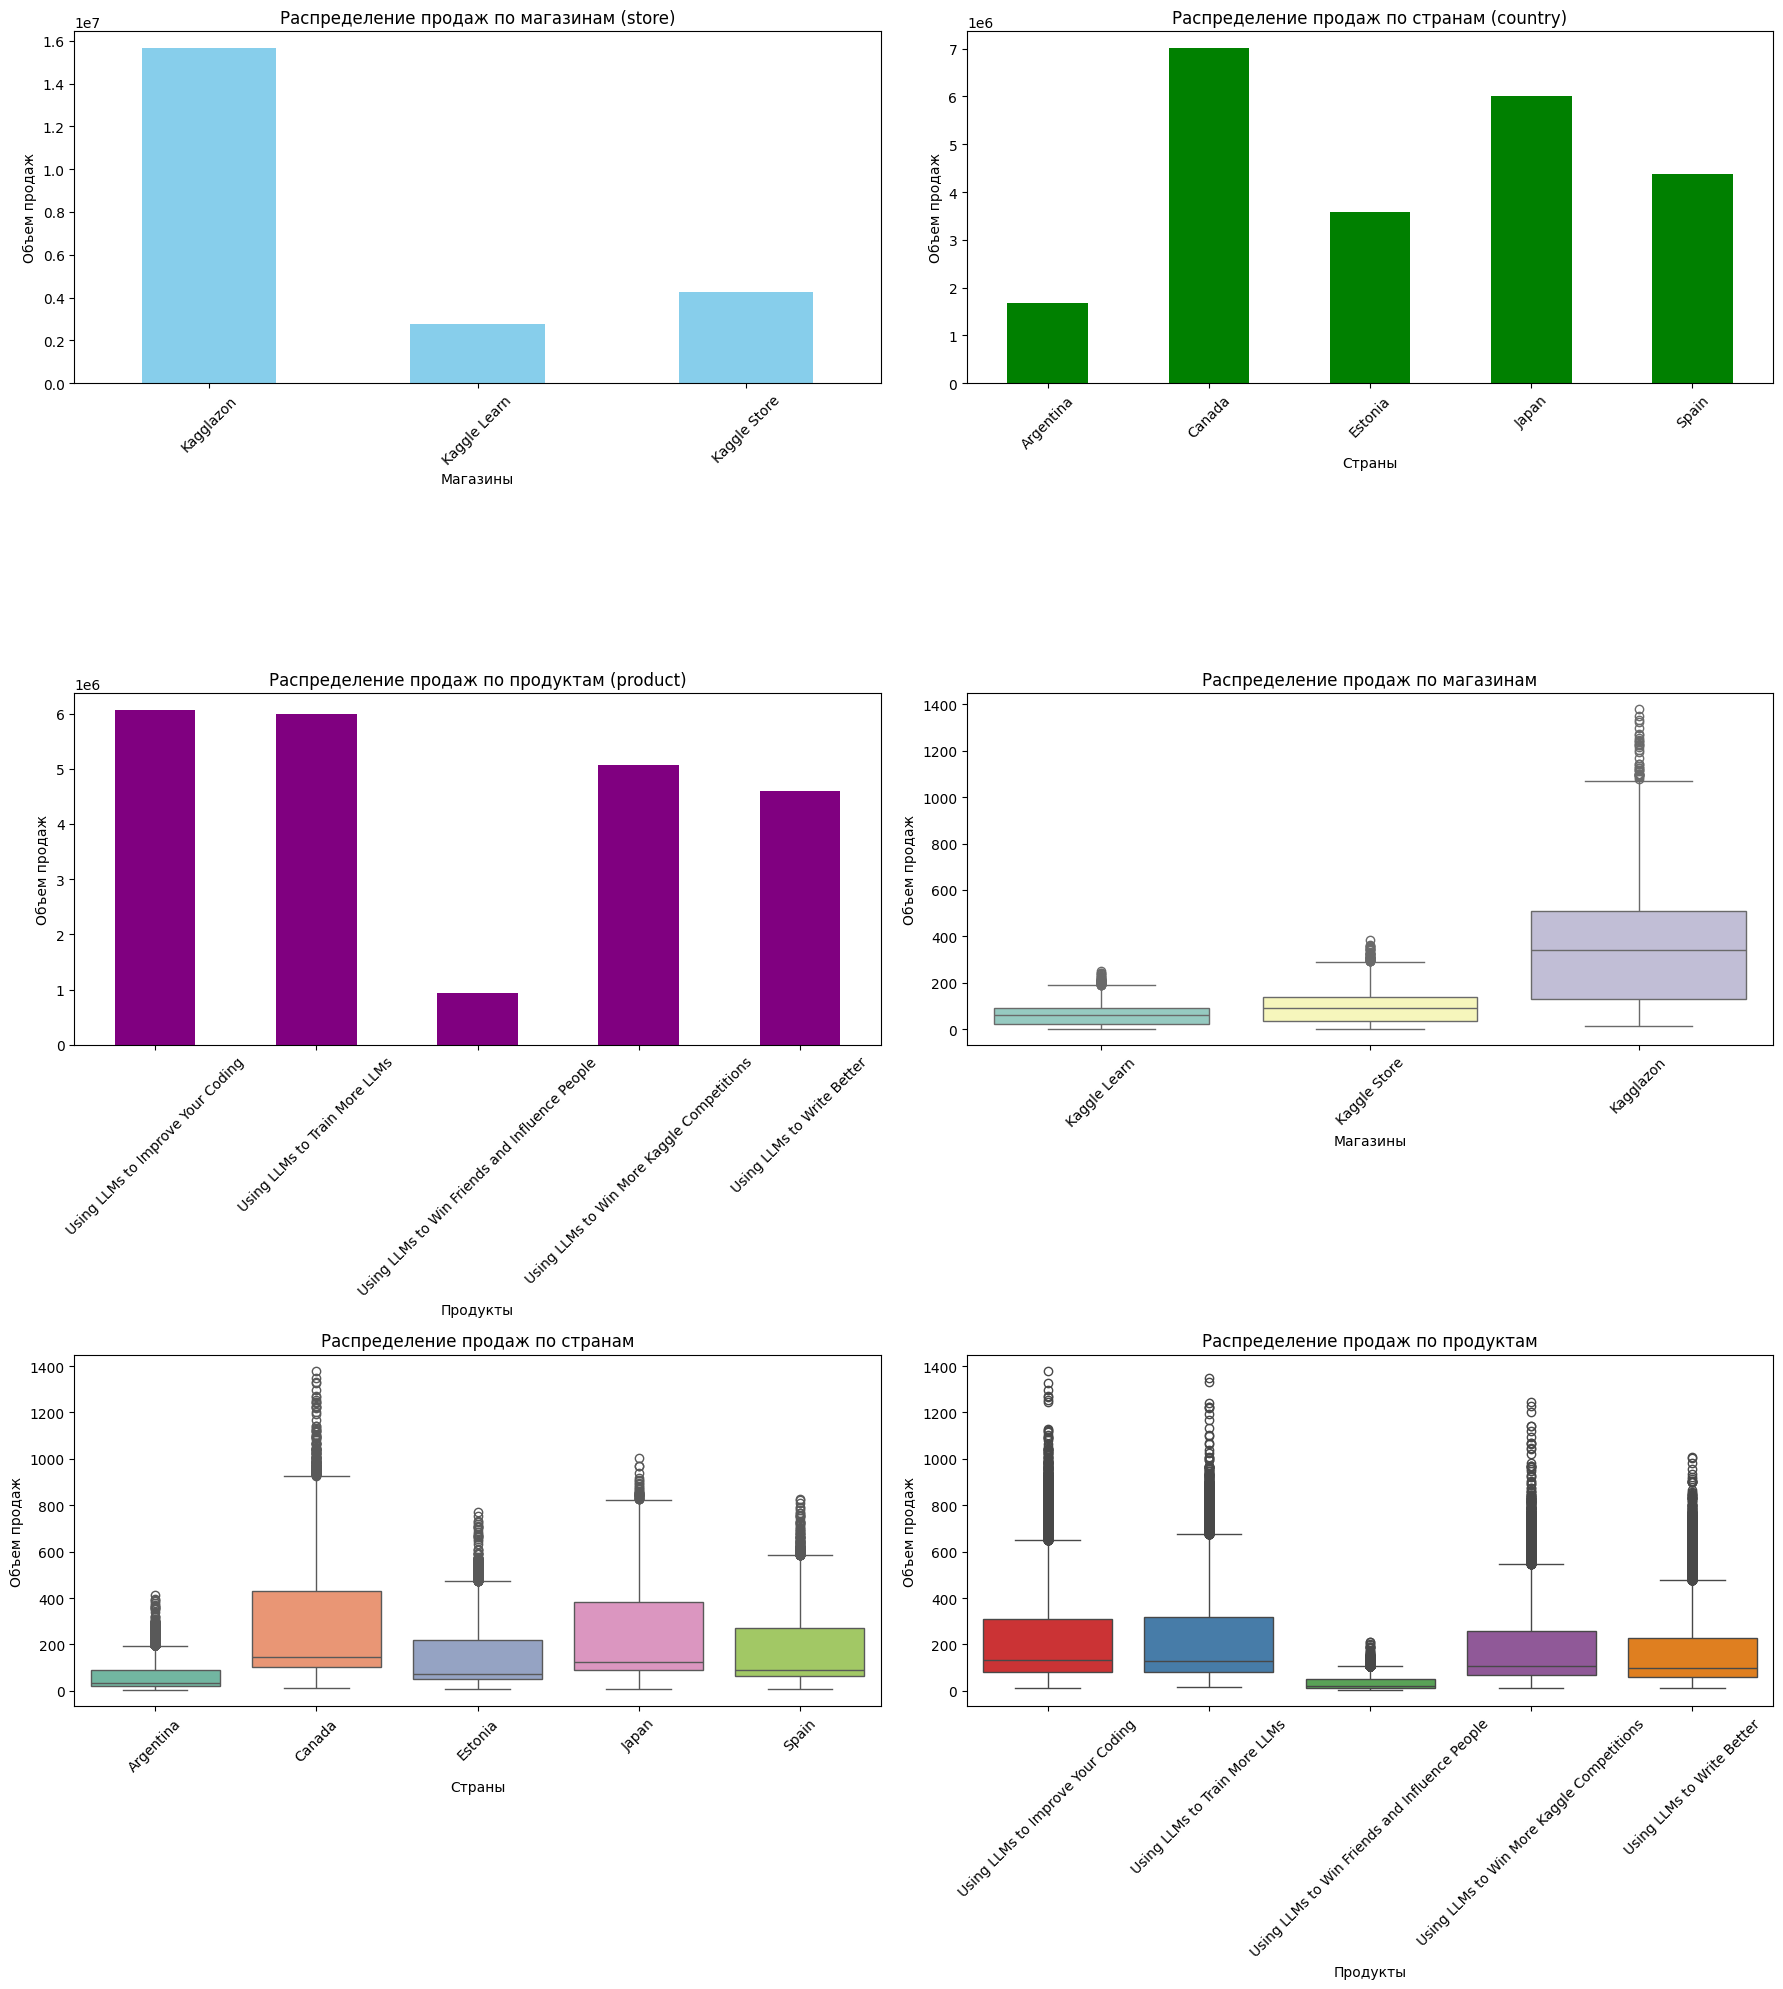

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(18, 20))  # 3 строки и 2 столбца графиков

# 1. Продажи по магазинам (store)
store_sales = data.groupby('store')['num_sold'].sum()
store_sales.plot(kind='bar', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title("Распределение продаж по магазинам (store)")
axes[0, 0].set_xlabel("Магазины")
axes[0, 0].set_ylabel("Объем продаж")
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Продажи по странам (country)
country_sales = data.groupby('country')['num_sold'].sum()
country_sales.plot(kind='bar', color='green', ax=axes[0, 1])
axes[0, 1].set_title("Распределение продаж по странам (country)")
axes[0, 1].set_xlabel("Страны")
axes[0, 1].set_ylabel("Объем продаж")
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Продажи по продуктам (product)
product_sales = data.groupby('product')['num_sold'].sum()
product_sales.plot(kind='bar', color='purple', ax=axes[1, 0])
axes[1, 0].set_title("Распределение продаж по продуктам (product)")
axes[1, 0].set_xlabel("Продукты")
axes[1, 0].set_ylabel("Объем продаж")
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Boxplot: Распределение продаж по магазинам
sns.boxplot(
    data=data,
    x='store',
    y='num_sold',
    hue='store',
    palette='Set3',
    dodge=False,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Распределение продаж по магазинам")
axes[1, 1].set_xlabel("Магазины")
axes[1, 1].set_ylabel("Объем продаж")
axes[1, 1].tick_params(axis='x', rotation=45)
# Check if legend exists before removing
if axes[1, 1].legend_ is not None:
    axes[1, 1].legend_.remove()

# 5. Boxplot: Распределение продаж по странам
sns.boxplot(
    data=data,
    x='country',
    y='num_sold',
    hue='country',
    palette='Set2',
    dodge=False,
    ax=axes[2, 0]
)
axes[2, 0].set_title("Распределение продаж по странам")
axes[2, 0].set_xlabel("Страны")
axes[2, 0].set_ylabel("Объем продаж")
axes[2, 0].tick_params(axis='x', rotation=45)
if axes[2, 0].legend_ is not None:
    axes[2, 0].legend_.remove()

# 6. Boxplot: Распределение продаж по продуктам
sns.boxplot(
    data=data,
    x='product',
    y='num_sold',
    hue='product',
    palette='Set1',
    dodge=False,
    ax=axes[2, 1]
)
axes[2, 1].set_title("Распределение продаж по продуктам")
axes[2, 1].set_xlabel("Продукты")
axes[2, 1].set_ylabel("Объем продаж")
axes[2, 1].tick_params(axis='x', rotation=45)
if axes[2, 1].legend_ is not None:
    axes[2, 1].legend_.remove()

plt.tight_layout()

plt.show()


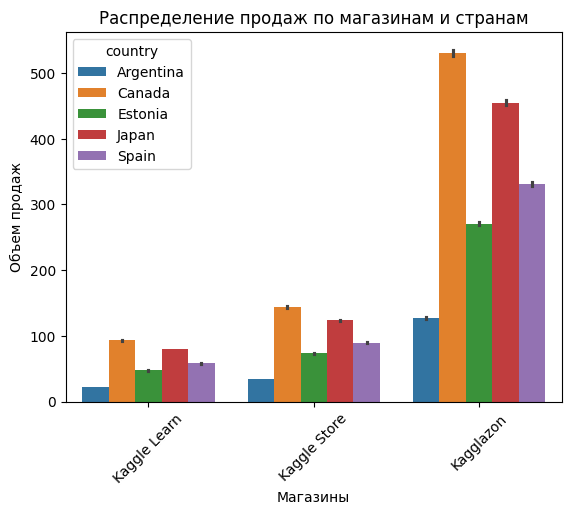

In [19]:
sns.barplot(data=data, x='store', y='num_sold', hue='country')
plt.title("Распределение продаж по магазинам и странам")
plt.xlabel("Магазины")
plt.ylabel("Объем продаж")
plt.xticks(rotation=45)
plt.show()

# Временной анализ 

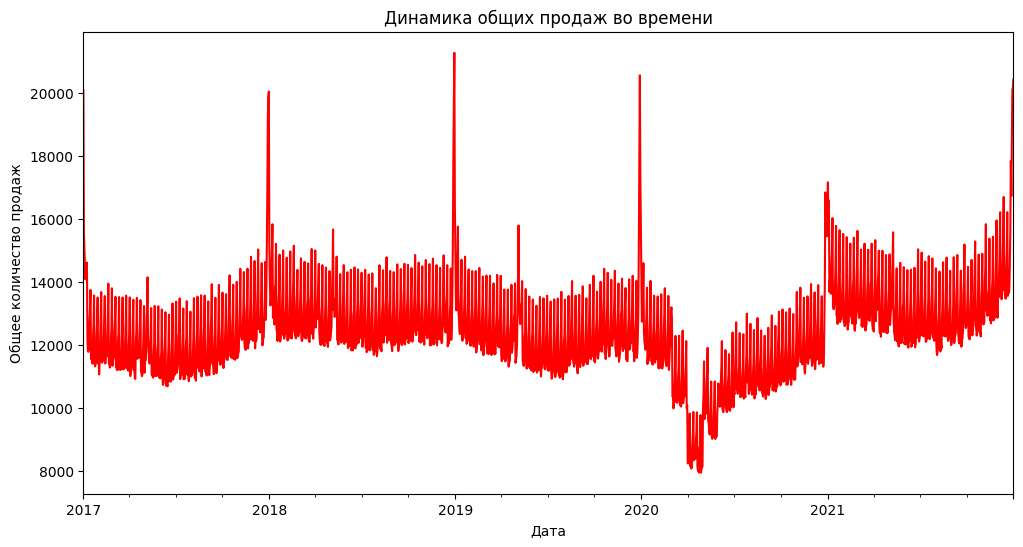

In [20]:
# Общая динамика продаж
time_sales = data.groupby('date')['num_sold'].sum()
plt.figure(figsize=(12, 6))
time_sales.plot(color='red')
plt.title("Динамика общих продаж во времени")
plt.xlabel("Дата")
plt.ylabel("Общее количество продаж")
plt.show()

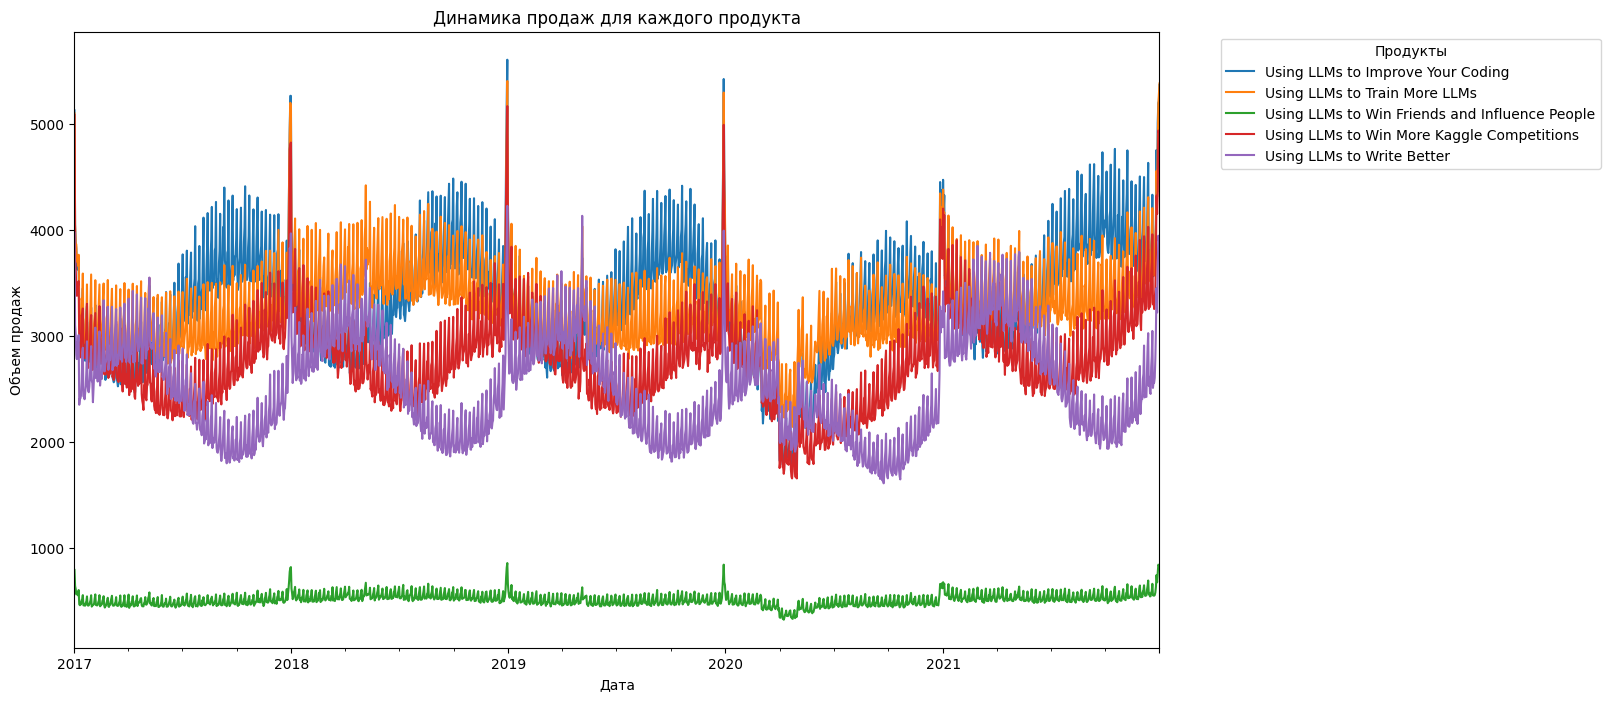

In [21]:
# Динамика продаж для каждого продукта
product_time_sales = data.groupby(['date', 'product'])['num_sold'].sum().unstack()
product_time_sales.plot(figsize=(14, 8))
plt.title("Динамика продаж для каждого продукта")
plt.xlabel("Дата")
plt.ylabel("Объем продаж")
plt.legend(title="Продукты", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

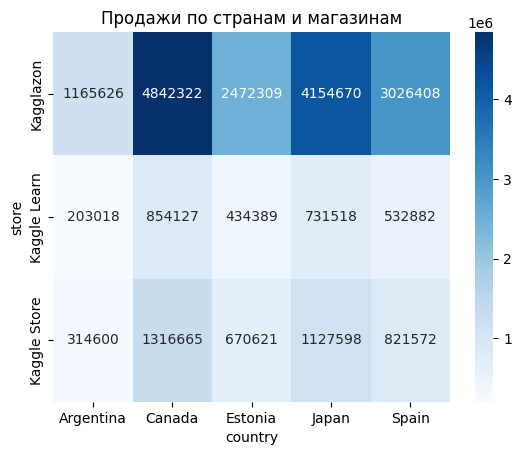

In [22]:
pivot_table = data.pivot_table(values='num_sold', index='store', columns='country', aggfunc='sum')
sns.heatmap(pivot_table, cmap="Blues", annot=True, fmt=".0f")
plt.title("Продажи по странам и магазинам")
plt.show()

# Прогнозирование продаж

RMSE: 1189.99
MAE: 911.06
MAPE: 7.30%



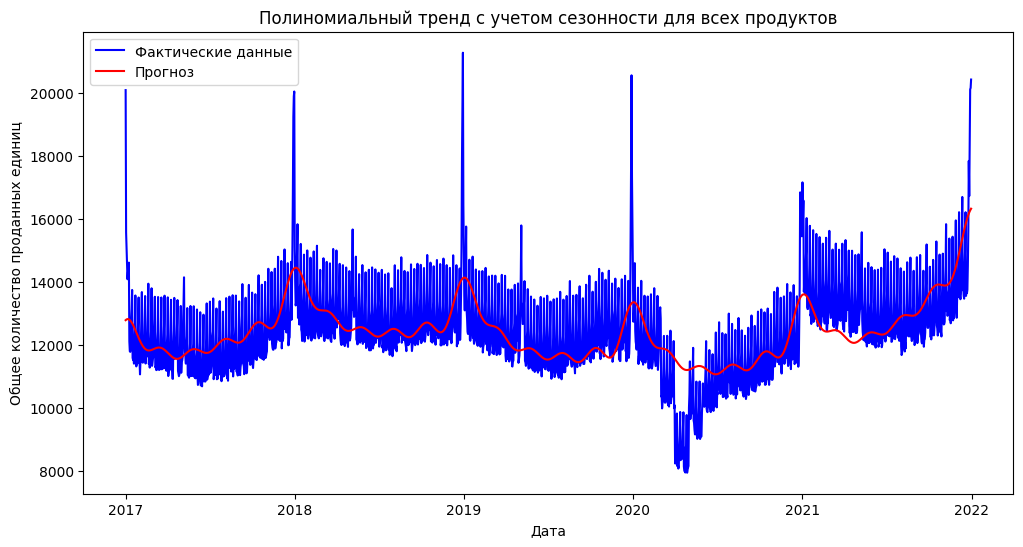

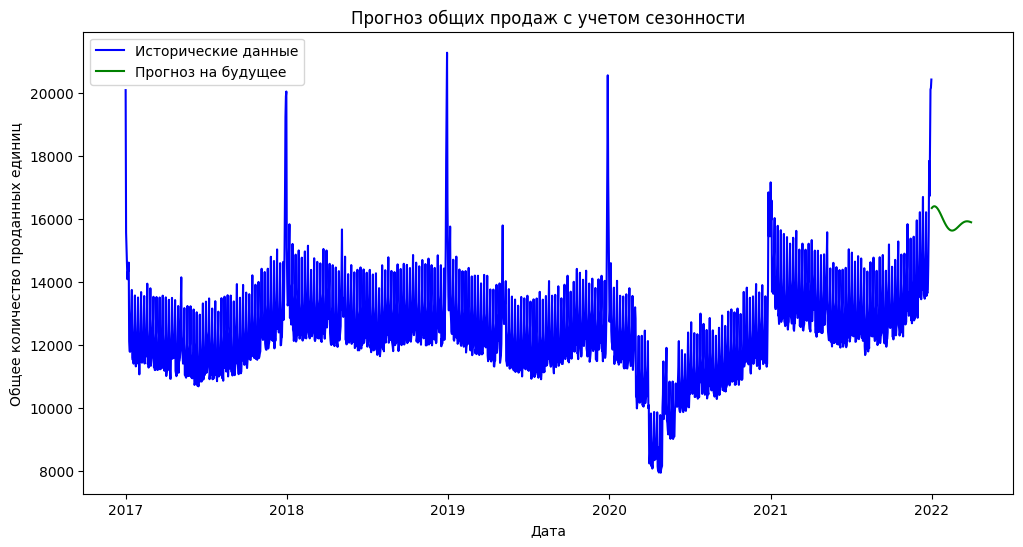

Анализ для продукта: Using LLMs to Improve Your Coding
RMSE: 321.87
MAE: 248.45
MAPE: 7.57%



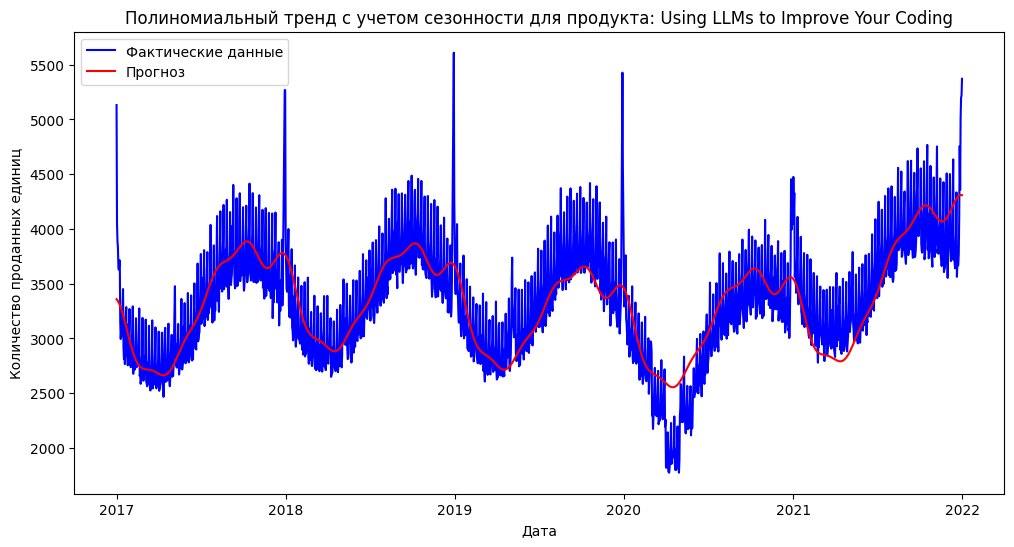

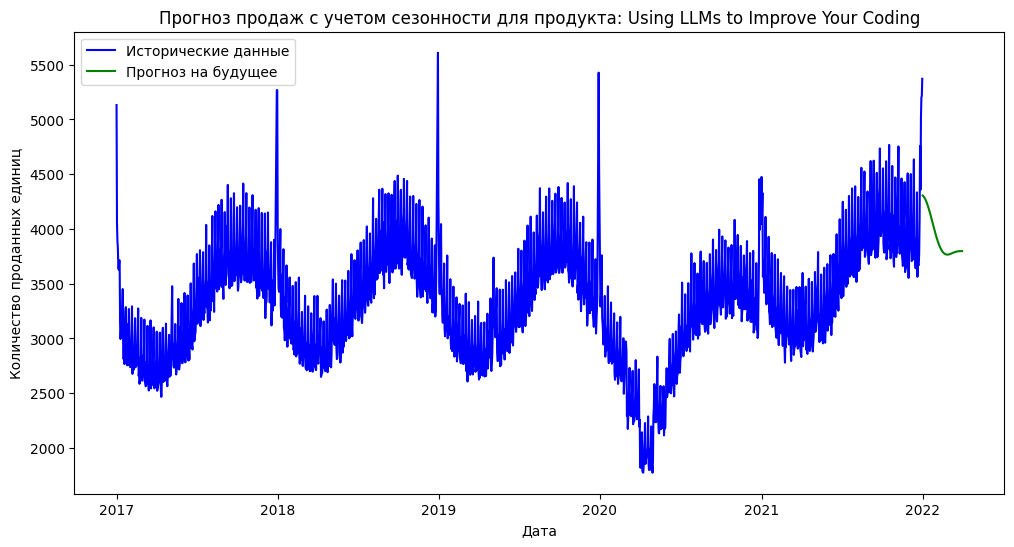

Анализ для продукта: Using LLMs to Train More LLMs
RMSE: 316.78
MAE: 244.98
MAPE: 7.39%



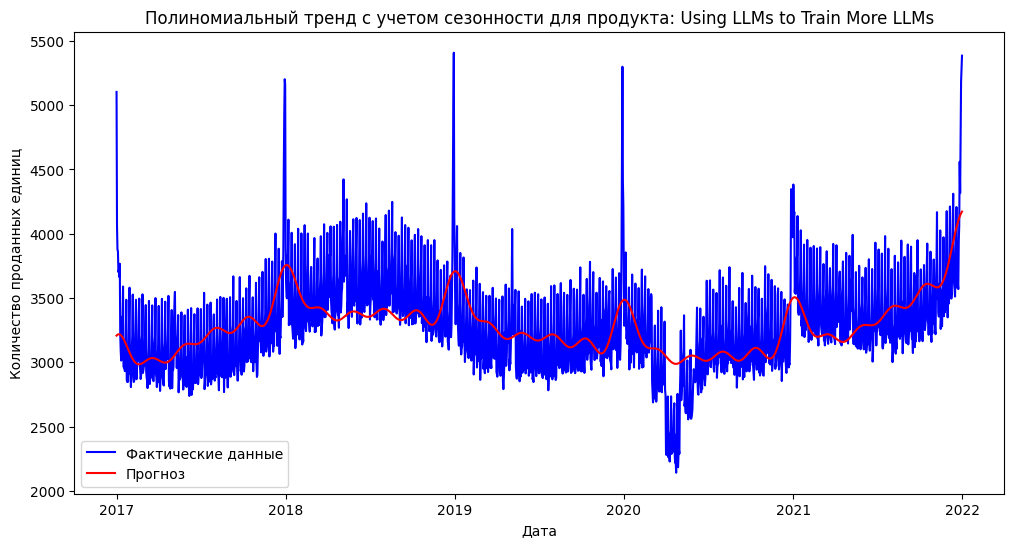

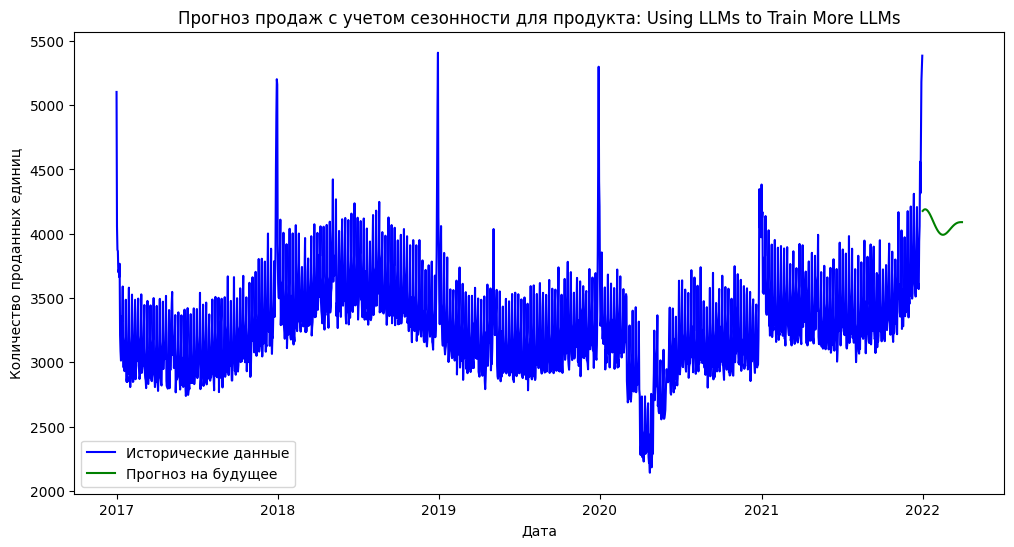

Анализ для продукта: Using LLMs to Win Friends and Influence People
RMSE: 49.39
MAE: 38.00
MAPE: 7.38%



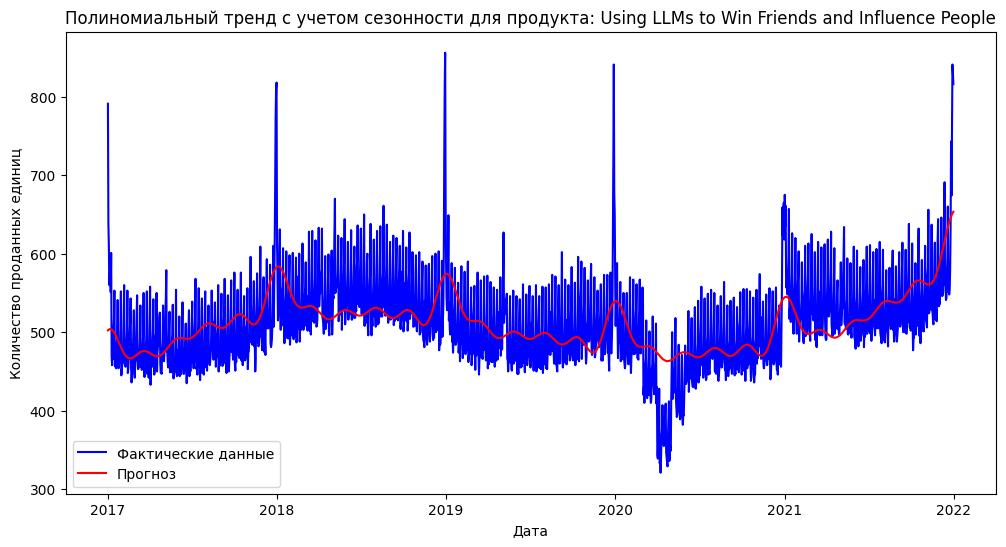

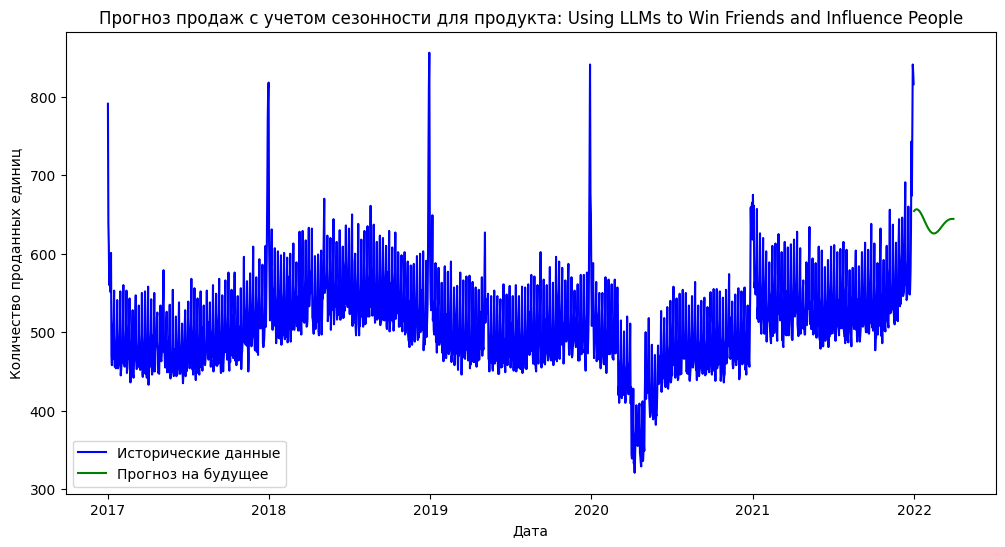

Анализ для продукта: Using LLMs to Win More Kaggle Competitions
RMSE: 280.62
MAE: 210.75
MAPE: 7.57%



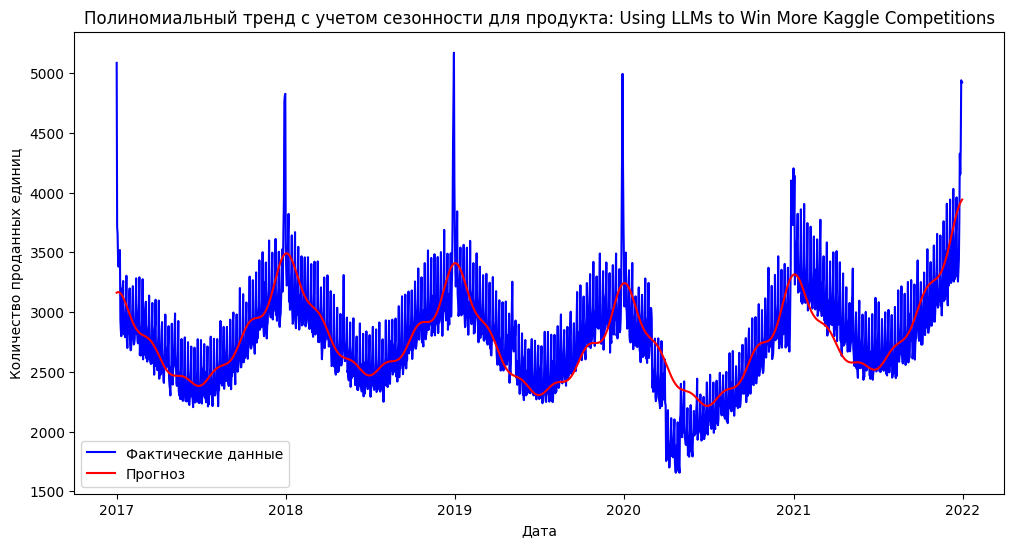

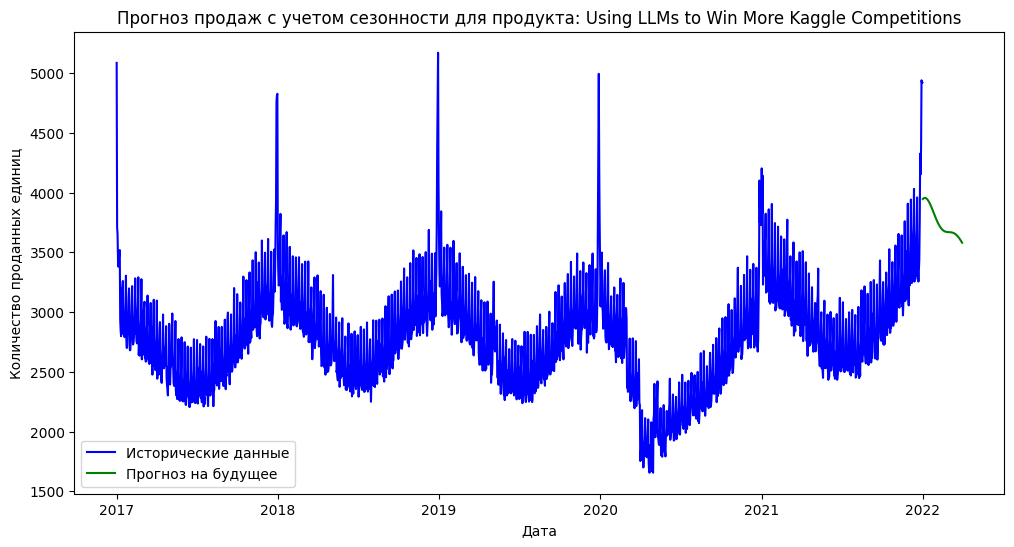

Анализ для продукта: Using LLMs to Write Better
RMSE: 266.75
MAE: 198.90
MAPE: 7.81%



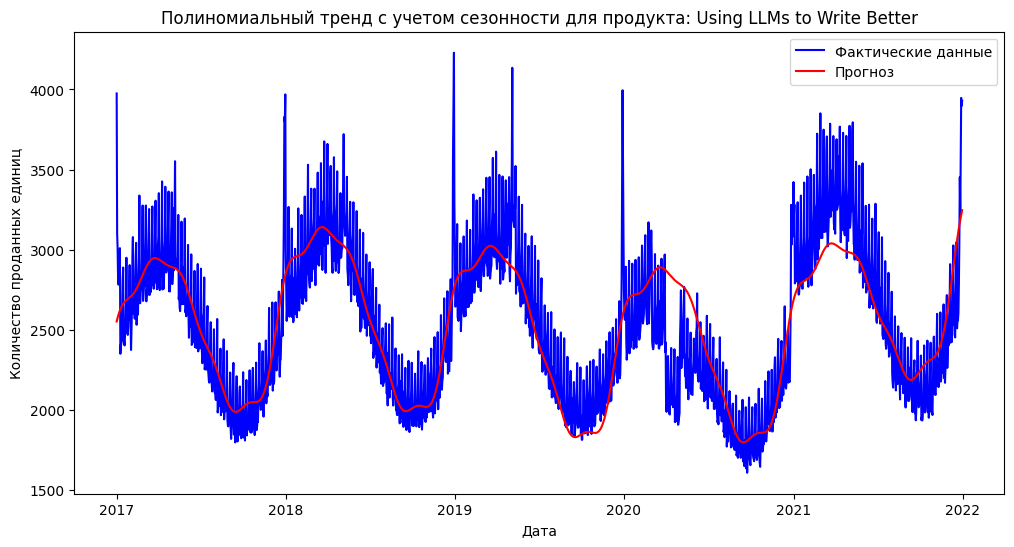

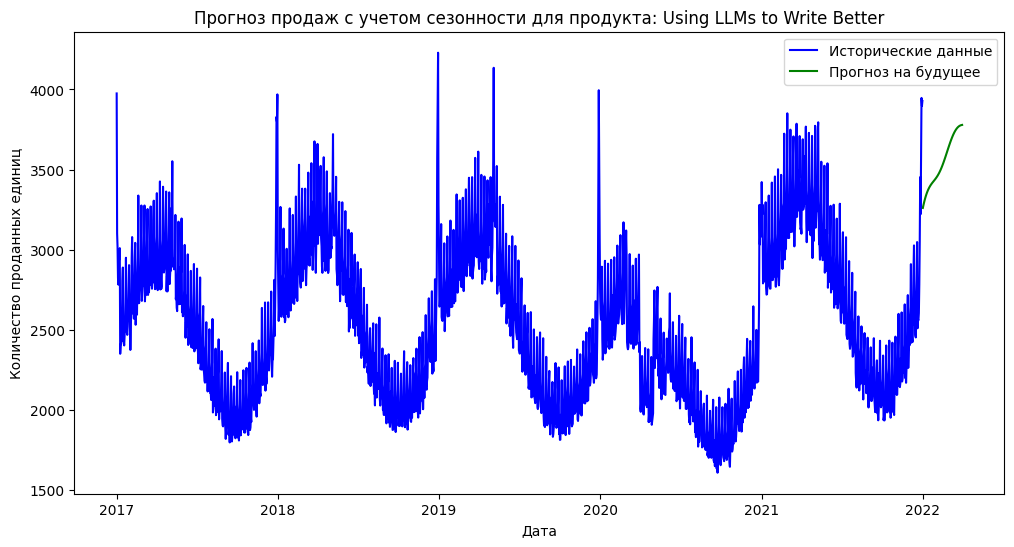

Результаты анализа для всех продуктов:
                                           product         RMSE         MAE  \
0                                     All Products  1189.990746  911.064091   
1                Using LLMs to Improve Your Coding   321.867364  248.447192   
2                    Using LLMs to Train More LLMs   316.779951  244.980910   
3   Using LLMs to Win Friends and Influence People    49.386998   37.997689   
4       Using LLMs to Win More Kaggle Competitions   280.621247  210.747616   
5                       Using LLMs to Write Better   266.745345  198.902017   
6                                     All Products  1189.990746  911.064091   
7                Using LLMs to Improve Your Coding   321.867364  248.447192   
8                    Using LLMs to Train More LLMs   316.779951  244.980910   
9   Using LLMs to Win Friends and Influence People    49.386998   37.997689   
10      Using LLMs to Win More Kaggle Competitions   280.621247  210.747616   
11           

In [26]:
# Группировка данных по дате без фильтрации по продукту
daily_sales_all = data.groupby('date')['num_sold'].sum()
daily_sales_all = daily_sales_all.asfreq('D')
daily_sales_all = daily_sales_all.fillna(0)

# Создаем признаки Фурье для сезонности
fourier_all = CalendarFourier(freq='YE', order=5)  # Годовая сезонность, 5 гармоник

# Определяем полиномиальный тренд 
dp_all = DeterministicProcess(
    index=daily_sales_all.index,
    constant=True,             # Константа 
    order=3,                   # Полиномиальный тренд 3-го порядка
    seasonal=False,            # Отключаем автоматические сезонные индикаторы
    additional_terms=[fourier_all],  # Добавляем признаки Фурье
    drop=True,
)

X_all = dp_all.in_sample()
y_all = daily_sales_all

# Обучение модели на общих данных
model_all = LinearRegression()
model_all.fit(X_all, y_all)

# Прогноз на обучающей выборке
y_pred_all = pd.Series(model_all.predict(X_all), index=X_all.index)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Вычисление метрик ошибки
rmse = root_mean_squared_error(y_all, y_pred_all)
mae = mean_absolute_error(y_all, y_pred_all)
mape = (np.abs(y_all - y_pred_all) / y_all.replace(0, np.nan)).mean() * 100  # Обрабатываем деление на ноль

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%\n")

# Сохраняем результаты
# Инициализируем список для хранения результатов
try:
    results
except NameError:
    results = []

results.append({
    'product': 'All Products',
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
})

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(y_all.index, y_all, label='Фактические данные', color='blue')
plt.plot(y_pred_all.index, y_pred_all, label='Прогноз', color='red')
plt.title("Полиномиальный тренд с учетом сезонности для всех продуктов")
plt.xlabel("Дата")
plt.ylabel("Общее количество проданных единиц")
plt.legend()
plt.show()

# Прогнозирование на будущее 
future_dates_all = pd.date_range(start=daily_sales_all.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
X_future_all = dp_all.out_of_sample(steps=90)
y_future_all = pd.Series(model_all.predict(X_future_all), index=future_dates_all)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(y_all.index, y_all, label='Исторические данные', color='blue')
plt.plot(y_future_all.index, y_future_all, label='Прогноз на будущее', color='green')
plt.title("Прогноз общих продаж с учетом сезонности")
plt.xlabel("Дата")
plt.ylabel("Общее количество проданных единиц")
plt.legend()
plt.show()

# Анализ по каждому продукту -

# Получаем список уникальных продуктов
product_list = data['product'].unique()

# Цикл по каждому продукту
for product_name in product_list:
    print(f"Анализ для продукта: {product_name}")
    
    # Фильтрация данных по продукту
    data_modules = data[data['product'] == product_name]
    
    # Проверяем, что после фильтрации данные не пустые
    if data_modules.empty:
        print(f"Нет данных для продукта: {product_name}")
        continue  
    
    # Группировка данных по дате
    daily_sales = data_modules.groupby('date')['num_sold'].sum()
    daily_sales = daily_sales.asfreq('D')
    daily_sales = daily_sales.fillna(0)
    
    # Создаем признаки Фурье для сезонности
    fourier = CalendarFourier(freq='YE', order=5)  
    
    # Определяем полиномиальный тренд 
    dp = DeterministicProcess(
        index=daily_sales.index,
        constant=True,             # Константа 
        order=3,                   # Полиномиальный тренд 3-го порядка
        seasonal=False,            # Отключаем автоматические сезонные индикаторы
        additional_terms=[fourier],  # Добавляем признаки Фурье
        drop=True,
    )
    
    X = dp.in_sample()
    y = daily_sales
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Прогноз на обучающей выборке
    y_pred = pd.Series(model.predict(X), index=X.index)
    
    
    # Вычисление метрик ошибки
    rmse = root_mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = (np.abs(y - y_pred) / y.replace(0, np.nan)).mean() * 100  # Обрабатываем деление на ноль
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%\n")
    
    # Сохраняем результаты
    results.append({
        'product': product_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    
    # Визуализация результатов 
    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Фактические данные', color='blue')
    plt.plot(y_pred.index, y_pred, label='Прогноз', color='red')
    plt.title(f"Полиномиальный тренд с учетом сезонности для продукта: {product_name}")
    plt.xlabel("Дата")
    plt.ylabel("Количество проданных единиц")
    plt.legend()
    plt.show()
    
    # Прогнозирование на будущее
    future_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
    X_future = dp.out_of_sample(steps=90)
    y_future = pd.Series(model.predict(X_future), index=future_dates)
    
    # Визуализация прогноза
    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Исторические данные', color='blue')
    plt.plot(y_future.index, y_future, label='Прогноз на будущее', color='green')
    plt.title(f"Прогноз продаж с учетом сезонности для продукта: {product_name}")
    plt.xlabel("Дата")
    plt.ylabel("Количество проданных единиц")
    plt.legend()
    plt.show()
    
# После цикла собираем результаты в DataFrame и выводим
results_df = pd.DataFrame(results)
print("Результаты анализа для всех продуктов:")
print(results_df)


# Прогнозирование продаж учебных модулей

## Метод полиномиального тренда с признаками Фурье

### Введение

**Полиномиальный тренд с признаками Фурье** — это метод прогнозирования временных рядов, который сочетает в себе полиномиальную регрессию для моделирования тренда и гармонические функции для учёта сезонности. Этот подход эффективен для прогнозирования показателей, которые имеют нелинейный тренд и выраженные сезонные колебания.

### Основные шаги метода

#### Шаг 1: Постановка задачи

Цель состоит в прогнозировании продаж учебных модулей на основе исторических данных о продажах. Необходимо учитывать как общий тренд развития продаж, так и сезонные колебания, связанные с определёнными периодами (например, начало учебного года, праздники и т.д.).

#### Шаг 2: Моделирование тренда с помощью полиномиальной регрессии

Полиномиальная регрессия расширяет линейную регрессию путём добавления степеней признаков, что позволяет моделировать нелинейные зависимости. Общая форма полиномиальной регрессии степени \( n \):

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots + \beta_n x^n + \epsilon
$$

Где:

- \( y \) — прогнозируемая переменная (продажи).
- \( x \) — независимая переменная (время).
- \( \beta_0, \beta_1, \ldots, \beta_n \) — коэффициенты модели.
- \( \epsilon \) — ошибка модели.

#### Шаг 3: Учёт сезонности с помощью признаков Фурье

Сезонные колебания моделируются с использованием гармонических функций (синусов и косинусов). Признаки Фурье позволяют учесть сложные периодические паттерны в данных.

Формулы для признаков Фурье:

$$
\begin{cases}
\sin\left( \dfrac{2\pi k t}{T} \right), \\
\cos\left( \dfrac{2\pi k t}{T} \right),
\end{cases}
$$

Где:

- \( t \) — время.
- \( T \) — период сезонности (например, 365 дней для годовой сезонности).
- \( k \) — порядок гармоники (число циклов в периоде).

#### Шаг 4: Комбинирование тренда и сезонности

Итоговая модель сочетает полиномиальный тренд и сезонные компоненты:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots + \beta_n x^n + \sum_{k=1}^{K} \left( \gamma_k \sin\left( \dfrac{2\pi k t}{T} \right) + \delta_k \cos\left( \dfrac{2\pi k t}{T} \right) \right) + \epsilon
$$

Где \( K \) — число гармоник.

#### Шаг 5: Оптимизация параметров

Коэффициенты модели (\( \beta \), \( \gamma \), \( \delta \)) оптимизируются с использованием методов линейной регрессии, обычно через метод наименьших квадратов, чтобы минимизировать разницу между прогнозируемыми и фактическими значениями продаж.

### Преимущества метода

- **Гибкость в моделировании тренда**: Полиномиальная регрессия позволяет учитывать сложные нелинейные тренды.
- **Учёт сложной сезонности**: Признаки Фурье эффективно моделируют сезонные колебания любой сложности.
- **Интерпретируемость**: Модель предоставляет понятные коэффициенты, отражающие влияние тренда и сезонности.
- **Применимость к различным временным рядам**: Метод подходит для данных с различными паттернами.

### Применение в данной работе

В этом проекте метод полиномиального тренда с признаками Фурье используется для прогнозирования продаж учебных модулей. Исторические данные о ежедневных продажах анализируются для выявления трендов и сезонных компонентов, которые затем используются для построения модели.

### Методы и этапы анализа

#### 1. Исследовательский анализ данных (EDA)

- **Обзор данных**:
  - Проверка размерности и типов данных.
  - Выявление пропущенных значений и их обработка.
- **Анализ распределения продаж**:
  - Построение гистограмм и диаграмм размаха для понимания распределения данных и выявления выбросов.
- **Анализ временных рядов**:
  - Построение графиков продаж во времени для выявления трендов и сезонности.
- **Анализ влияния категориальных переменных**:
  - Исследование влияния различных факторов (магазин, страна, продукт) на продажи.

#### 2. Построение модели

- **Создание признаков Фурье**:
  - Использование `CalendarFourier` для генерации гармонических функций, учитывающих годовую сезонность.
- **Определение полиномиального тренда**:
  - Выбор степени полинома (например, степень 3 для кубического тренда).
- **Комбинирование тренда и сезонности**:
  - Создание матрицы признаков, включающей полиномиальные и сезонные компоненты.
- **Обучение модели**:
  - Применение линейной регрессии для оптимизации коэффициентов модели.

#### 3. Оценка модели

- **Расчёт метрик качества**:
  - **RMSE (Корень из среднеквадратичной ошибки)**: Оценка среднеквадратичного отклонения прогнозов от фактических значений.
  - **MAE (Средняя абсолютная ошибка)**: Среднее абсолютное отклонение прогнозов.
  - **MAPE (Средняя абсолютная процентная ошибка)**: Средний процент отклонения прогнозов.

### Результаты анализа

#### **Сводная таблица метрик для всех продуктов**

| №  | Продукт                                               | RMSE        | MAE         | MAPE (%) |
|----|-------------------------------------------------------|-------------|-------------|----------|
| 0  | **Все продукты**                                      | **1189.99** | **911.06**  | **7.30** |
| 1  | Using LLMs to Improve Your Coding                     | 321.87      | 248.45      | 7.57     |
| 2  | Using LLMs to Train More LLMs                         | 316.78      | 244.98      | 7.39     |
| 3  | Using LLMs to Win Friends and Influence People        | 49.39       | 38.00       | 7.38     |
| 4  | Using LLMs to Win More Kaggle Competitions            | 280.62      | 210.75      | 7.57     |
| 5  | Using LLMs to Write Better                            | 266.75      | 198.90      | 7.81     |

#### **Интерпретация результатов**

- **Общая модель для всех продуктов**:
  - **RMSE**: 1189.99
  - **MAE**: 911.06
  - **MAPE**: 7.30%
  - **Интерпретация**: Средняя ошибка прогноза составляет около 7.30% от фактических значений общих продаж, что свидетельствует о высокой точности модели в относительных терминах. Абсолютные значения ошибок выше из-за суммирования продаж по всем продуктам.

- **Модели для отдельных продуктов**:
  - **Сравнительно низкие значения RMSE и MAE** для каждого продукта показывают, что модели хорошо справляются с прогнозированием продаж на индивидуальном уровне.
  - **MAPE для отдельных продуктов** варьируется от **7.38% до 7.81%**, что указывает на стабильную точность моделей для всех продуктов.

- **Особенности отдельных продуктов**:
  - **"Using LLMs to Win Friends and Influence People"** имеет наименьшие значения RMSE и MAE, что может свидетельствовать о более стабильных продажах и меньшей вариабельности данных для этого продукта.
  - **Другие продукты** имеют схожие метрики, что говорит о консистентности модели в прогнозировании разных продуктов.

#### **Важность признаков**

- **Полиномиальный тренд** успешно моделирует общий рост или снижение продаж для каждого продукта и в целом.
- **Признаки Фурье** эффективно улавливают сезонные колебания, связанные с годовым циклом, позволяя модели адаптироваться к периодическим изменениям в данных.

### Заключение

Применение метода полиномиального тренда с признаками Фурье позволило:

- **Эффективно смоделировать сложный характер продаж** учебных модулей, учитывая как нелинейный тренд, так и сезонные колебания.
- **Достичь высокой точности прогнозирования**, что подтверждается низкими значениями ошибок (RMSE, MAE, MAPE) для всех моделей.
- **Предоставить инструмент для бизнес-планирования**, позволяющий прогнозировать будущие продажи как на уровне отдельных продуктов, так и в целом.

### Преимущества выбранного подхода

- **Гибкость и адаптивность**:
  - Возможность моделирования сложных зависимостей без необходимости использования более сложных моделей машинного обучения.
- **Интерпретируемость результатов**:
  - Коэффициенты модели позволяют понять вклад каждого компонента в общий прогноз.
- **Простота реализации**:
  - Метод основывается на хорошо известных статистических подходах и не требует значительных вычислительных ресурсов.

